In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

  Using cached tensorflow-2.8.0-cp39-cp39-win_amd64.whl (438.0 MB)
  Using cached libclang-13.0.0-py2.py3-none-win_amd64.whl (13.9 MB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached wrapt-1.14.0-cp39-cp39-win_amd64.whl (36 kB)
  Using cached protobuf-3.20.0-cp39-cp39-win_amd64.whl (904 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached h5py-3.6.0-cp39-cp39-win_amd64.whl (2.8 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached grpcio-1.44.0-cp39-cp39-win_amd64.whl (3.4 MB)
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("=============IMPORT LIBRARIES FINISHED==================================")

=============IMPORT LIBRARIES FINISHED==================================


In [3]:
import pathlib
PATH='/Users/santi/rockPaperSic/'

data_dir = os.path.join(PATH, 'train')
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.JPG'))  + list(data_dir.glob('*/*.png'))  + list(data_dir.glob('*/*.PNG')) + list(data_dir.glob('*/*.jfif')) + list(data_dir.glob('*/*.JFIF')))   
print("TOTAL IMAGES: ")
print(image_count)

print("=============PATH SETUP FINISHED==================================")

TOTAL IMAGES: 
5040
=============PATH SETUP FINISHED==================================


In [4]:
#Setup basic parameters
batch_size = 32 #cada 32 se acatualiza el gradinnte 
img_height = 300 # normaliza las imagenes a este tamaños
img_width = 300

#Setup training dataset
print("TRAINING DATASET:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Setup testing dataset
print("\nTESTING DATASET:")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("\nCLASS NAMES:")
class_names = train_ds.class_names
print(class_names)

TRAINING DATASET:
Found 2520 files belonging to 3 classes.
Using 2016 files for training.

TESTING DATASET:
Found 2520 files belonging to 3 classes.
Using 504 files for validation.

CLASS NAMES:
['paper', 'rock', 'scissors']


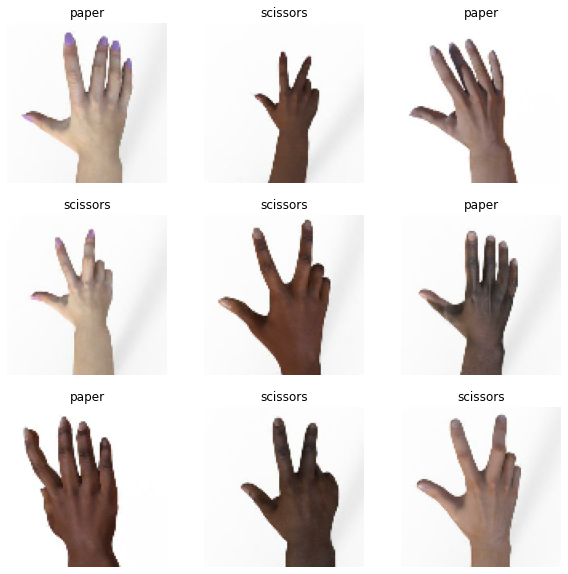

In [5]:
#Here are the first 9 images from the training dataset.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [63]:
#Size of batch for training images
for image_batch, labels_batch in train_ds:
  print("IMAGE BATCH SHAPE: ", image_batch.shape)
  print("LABELS BATCH SHAPE: ", labels_batch.shape)
  break

IMAGE BATCH SHAPE:  (32, 300, 300, 3)
LABELS BATCH SHAPE:  (32,)


In [64]:
AUTOTUNE = tf.data.AUTOTUNE
#sitonizacion de datos
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("===================AUTO-TUNE OK=================================")

===================AUTO-TUNE OK=================================


In [65]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)#divide los pixeles entre 255 para normalizar 

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

0.078431375 1.0


In [66]:
#aumentar los datos,
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation2 = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

num_classes = 3 #numero de capas

model = Sequential([
  data_augmentation,#capa 1
  #resize_and_rescale,
  #data_augmentation2,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  #kernels = filtros
])

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 300, 300, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                

In [69]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print("===================AUTO-TUNE OK=================================")

Epoch 1/15
63/63 [==============================] - 59s 929ms/step - loss: 0.9714 - accuracy: 0.5888 - val_loss: 0.3492 - val_accuracy: 0.8690
Epoch 2/15
63/63 [==============================] - 59s 939ms/step - loss: 0.2751 - accuracy: 0.9018 - val_loss: 0.1203 - val_accuracy: 0.9623
Epoch 3/15
63/63 [==============================] - 59s 941ms/step - loss: 0.1516 - accuracy: 0.9529 - val_loss: 0.1070 - val_accuracy: 0.9702
Epoch 4/15
63/63 [==============================] - 59s 941ms/step - loss: 0.1814 - accuracy: 0.9425 - val_loss: 0.0541 - val_accuracy: 0.9841
Epoch 5/15
63/63 [==============================] - 60s 954ms/step - loss: 0.0881 - accuracy: 0.9737 - val_loss: 0.0318 - val_accuracy: 0.9921
Epoch 6/15
63/63 [==============================] - 60s 960ms/step - loss: 0.0600 - accuracy: 0.9836 - val_loss: 0.0350 - val_accuracy: 0.9921
Epoch 7/15
63/63 [==============================] - 60s 961ms/step - loss: 0.1285 - accuracy: 0.9544 - val_loss: 0.0149 - val_accuracy: 0.9980

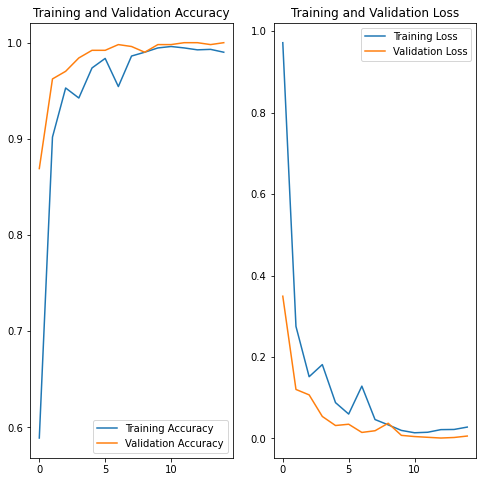

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
#/content/drive/MyDrive/SISTEMAS_I/
url = "file:/Users/santi/rockPaperSic/test/ejemplo2.jpeg"
path = tf.keras.utils.get_file('ejemplo2', origin=url)

img = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)
img_array= keras.preprocessing.image.img_to_array(img)
img_array= tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(str(class_names))
print(str(predictions))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

['paper', 'rock', 'scissors']
[[  2.5375857 -12.004939    7.850976 ]]
This image most likely belongs to scissors with a 99.51 percent confidence.


In [80]:
tf.keras.models.save_model(model, '/Users/santi/rockPaperSic/model_saved/')

INFO:tensorflow:Assets written to: /Users/santi/rockPaperSic/model_saved/assets


In [ ]:
import tensorflow as tf

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('RockModel.tflite', 'wb') as f:
  f.write(tflite_model)

print('DONE')